# SpikeDeeptector in Python

This notebook presents a Python implementation of the SpikeDeeptector, a model used to label extracellular recordings as containing neural activity or artifacts. The model was originally designed and published in **Saif-ur-Rehman, M. et al.** ***SpikeDeeptector: a deep-learning based method for detection of neural spiking activity.*** **J. Neural Eng. 16, (2019). doi:10.1088/1741-2552/ab1e63.** Matlab implementation: https://github.com/saifhanjra/SpikeDeeptector.

The notebook is structured as follows:

0. **Set up:** load dependencies and define functions.
1. **Build model:** reproduce CNN architecture and initialize it with the learnt parameters using Keras. 
2. **Evaluate model:** check that the outputs from the Matlab and Python models coincide.
3. **Use example:** load a raw trace from a .ns6 file, process it, and input it to the model.

## 0. Set up

In [1]:
import os
import sys
import hdf5storage
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

import brpylib

from scipy import signal
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

def preprocessing(X, mean): #mean=parameters['input_mean']
    """ Preprocess raw stacked waveforms by subtracting the learnt mean and adding a column of zeros on the left and right

    Args:
        X (numpy.array): raw stacked waveforms, i.e. input to the model
        mean (numpy.array): learnt mean

    Returns:
        numpy.array: processed stacked waveforms ready as input for the model
    """
    # Normalization ('zerocenter') 
    X_norm = np.zeros_like(X, dtype='float')
    for i in range(X.shape[0]):
        X_norm[i,:,:,0] = (X[i,:,:,0] - mean)
    # Zero-padding in the 'time direction'
    X_padded = np.pad(X_norm, pad_width=((0,0),(0,0),(1,1),(0,0)), mode='constant')
    return X_padded

def activations(X, layer_name, model):
    """ Given a model and an input, returns the activations of a given layer

    Args:
        X (numpy.array): model input
        layer_name (str): layer name whose activations are desired
        model_name (object): model to be used

    Returns:
        numpy.array: layer activations
    """
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    return intermediate_layer_model.predict(X_net)

def filter_signal(X, filter_type='high', filter_freqs=250, filter_order=5):
    """ Filter signal

    Args:
        X (numpy.array): signal
        filter_type (str): filter type {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
        filter_freqs (numpy.array, list): cutoff frequencies
        filter_order (numpy.array): filter order

    Returns:
        numpy.array: filtered signal
    """
    nyquist_freq = fs / 2
    filter_freqs_normalized = np.array(filter_freqs) / nyquist_freq
    b, a = signal.butter(filter_order, filter_freqs_normalized, btype=filter_type)
    return signal.filtfilt(b, a, X)

def threshold_signal(X, threshold, min_distance_between_crossings=1.6):
    """ Given a signal and a threshold, it returns the timestimaps of the upward threshold crossings

    Args:
        X (numpy.array): signal
        threshold (numpy.array): threshold
        min_distance_between_crossings (numpy.array): used to delete crossings too close in time

    Returns:
        numpy.array: upward crossings samplestamps
    """
    # Set as 1 all samples above threshold
    X_above_threshold = (X < threshold).astype(int)
    if (X_above_threshold==0).all()==True:
        accepted_crossings = np.array([])
    else:
        # Find the crossing by taking its difference
        X_diff = np.diff(X_above_threshold)
        # Find where the upward crossings happen
        upward_crossings = np.where(X_diff == 1)[0]
        # Calculate the distance between upward crossings
        distance_crossings = -np.diff(upward_crossings[::-1])
        # Make mask to indentfy detections which happen just afer another detection
        bool_crossings = np.append(True, (distance_crossings > min_distance_between_crossings)[::-1])
        # Mask them out because they are multiple detections of the same waveform
        accepted_crossings = upward_crossings[bool_crossings]
    return accepted_crossings

def extract_windows(X, detections, window_limits=[16,32]):
    """ Given a signal and detection points in samples, it returns signal windows with respect to those points.

    Args:
        X (numpy.array): signal
        detections (numpy.array): sample points to be used as reference
        window_limits (numpy.array, list): amount of samples that are taken from the left and right

    Returns:
        2D numpy.array: (n_waveforms, n_samples) stacked waveforms
        numpy.array: window start points
    """
    w_width = sum(window_limits)
    n_waveforms = detections.size
    w_start, w_end = detections - window_limits[0], detections + window_limits[1]
    w = np.zeros((n_waveforms, w_width))
    for i in range(n_waveforms):
        if (w_start[i] > 0) and (w_end[i] <= X.size):
            w[i] = X[w_start[i]:w_end[i]]
    return w, w_start

def plot_waveforms(waveforms, fs=30000,  window_limits=[16,32]):
    """ Visualize overlapped waveforms.

    Args:
        waveforms (2D numpy.array): (n_waveforms, n_samples) stacked waveforms
        fs (numpy.array): sampling frequency
        window_limits (numpy.array, list): waveform expansion to the left and right
    """
    time = np.arange(waveforms.shape[1])/fs*1000 # ms
    for waveform in waveforms:
        plt.plot(time, waveform, c='k', alpha=.05)
    plt.xlim([0, sum(window_limits)/fs*1000])
    plt.xlabel('Time [ms]')
    plt.ylabel('Voltage [uV]')
    plt.show()

## 1. Build model
Firstly, the model parameters are extracted from the Matlab file ``trainedModelDeepNetCNN.mat`` available in the original Matlab implementation repository. The function ``GetParameters.m`` accesses all required parameters from the Matlab object and saves them in ``parameters.mat``, which can be accessed in Python. Secondly, the model architecture is reproduced using Keras. For compatibility reasons, the original network design is splitted in 2 parts:
* ``model_head``: the CNN (Convolutional Neural Network)
* ``model_tail``: last FC (Fully Connected) layers.

In [2]:
# Load parameters
path_parameters = os.path.join(os.getcwd(), 'parameters.mat')
parameters_mat = hdf5storage.loadmat(path_parameters)

# Arrange them in a dictionary for direct initialization of the Keras model
parameters = {}
parameters[f'input_mean'] = parameters_mat['input_mean']
for i in range(1,7):
    parameters[f'conv{i}'] = [parameters_mat[f'conv{i}_weights'],
                              parameters_mat[f'conv{i}_bias'].squeeze()]
    parameters[f'norm{i}'] = [parameters_mat[f'norm{i}_gamma'].squeeze(), 
                              parameters_mat[f'norm{i}_beta'].squeeze(),
                              parameters_mat[f'norm{i}_runningMean'].squeeze(),
                              parameters_mat[f'norm{i}_runningVariance'].squeeze()]
for i in range(1,3):
    parameters[f'fc{i}'] = [parameters_mat[f'fc{i}_weights'].T,
                            parameters_mat[f'fc{i}_bias'].squeeze()]

# Reproduce model architecture and initialize it with learnt parameters
model_head = Sequential(name='head', layers=[
    Conv2D(25, (1, 3), weights=parameters['conv1'], name='conv_1', input_shape=(20, 50, 1)),
    BatchNormalization(epsilon=1e-5, weights=parameters['norm1'], name='batchnorm_1'),
    Activation('relu', name='relu_1'),
    Dropout(.5, name='dropout_1'),
    Conv2D(25, (20, 3), weights=parameters['conv2'], name='conv_2'),
    BatchNormalization(epsilon=1e-5, weights=parameters['norm2'], name='batchnorm_2'),
    Activation('relu', name='relu_2'),
    MaxPooling2D(pool_size=(1,2), strides=(1,1), name='maxpool_1'),
    Conv2D(50, (1, 3), weights=parameters['conv3'], name='conv_3'),
    BatchNormalization(epsilon=1e-5, weights=parameters['norm3'], name='batchnorm_3'),
    Activation('relu', name='relu_3'),
    Dropout(.5, name='dropout_2'),
    MaxPooling2D(pool_size=(1,2), strides=(1,1), name='maxpool_2'),
    Conv2D(100, (1, 3), weights=parameters['conv4'], name='conv_4'),
    BatchNormalization(epsilon=1e-5, weights=parameters['norm4'], name='batchnorm_4'),
    Activation('relu', name='relu_4'),
    MaxPooling2D(pool_size=(1,2), strides=(1,1), name='maxpool_3'),
    Conv2D(100, (1, 5), weights=parameters['conv5'], name='conv_5'),
    BatchNormalization(epsilon=1e-5, weights=parameters['norm5'], name='batchnorm_5'),
    Activation('relu', name='relu_5'),
    Dropout(.5, name='dropout_3'),
    MaxPooling2D(pool_size=(1,2), strides=(1,1), name='maxpool_4'),
    Conv2D(100, (1, 5), weights=parameters['conv6'], name='conv_6'),
    BatchNormalization(epsilon=1e-5, weights=parameters['norm6'], name='batchnorm_6'),
    Activation('relu', name='relu_6'),
    Dropout(.5, name='dropout_4'),
    MaxPooling2D(pool_size=(1,2), strides=(1,1), name='maxpool_5')])
model_tail = Sequential(name='tail', layers=[
    Dense(100, weights=parameters['fc1'], name='fc_1', input_shape=(1, 2900)),
    Activation('relu', name='relu_7'),
    Dense(2, weights=parameters['fc2'], name='fc_2'),
    Activation('softmax', name='softmax')])

model_head.summary()
model_tail.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 20, 48, 25)        100       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 20, 48, 25)        100       
_________________________________________________________________
relu_1 (Activation)          (None, 20, 48, 25)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 48, 25)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 1, 46, 25)         37525     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 1, 46, 25)         100       
__________

## 2. Evaluate model
Firstly, evaluation data is obtained from the Matlab implementation. The function ``GetEvaluationData.m`` loads a Utah array recording from a NEV file, generates the input and output of the model, and saves them in ``data_evaluation.mat``. Secondly, that same input is used in the Keras model to get an output which should be 100% coincident with the one from Matlab saved in the evaluation data for all the channels that are not broken. Note that the provided data comes from the ``Recording2.nev`` available in the original Matlab implementation repository.

In [3]:
# Load evaluation data
path_data = os.path.join(os.getcwd(), 'data_evaluation')
data_mat = hdf5storage.loadmat(path_data)['BatchesAndPredictions']
data = []
for ch in range(96):
    data.append([data_mat[0,ch][0][0][0][0], data_mat[0,ch][0][0][0][1]])
    
for ch in range(96):
    # Arrange evaluation data properly for direct input to the Keras model
    # Reshape input (n_inputs, n_waveforms, n_samples, 1)
    n_inputs = data[ch][0].shape[3]
    X = np.zeros((n_inputs, 20, 48, 1))
    for i in range(n_inputs):
        X[i,:,:,0] = data[ch][0][:,:,0,i]
    # Relabel predictions to match Keras output. In Matlab, 0 was saved for broken channels
    y = data[ch][1].flatten()
    y[y==1] = 0 # NEURONAL
    y[y==2] = 1 # ARTIFACTS
    
    # Predict feature map label for channel ch
    if y[0]==0:
        print(f'Channel {ch+1}: Broken electrode')
    else:
        # Preprocess input        
        X_preprocessed = preprocessing(X, mean=parameters['input_mean'])
        # Get model head output
        y_head = model_head.predict(X_preprocessed)
        # Flatten and reshape manually
        n_inputs = y_head.shape[0]
        X_FC = np.zeros((n_inputs, 1, 2900))
        for i in range(n_inputs):
            X_FC[i,0,:] = y_head[i].T.flatten()
        # Get model tail output, i.e. final prediction
        y_pred = model_tail.predict_classes(X_FC)
        # Check for coincidence
        print(f'Channel {ch+1}: {accuracy_score(y, y_pred)*100:.0f}% coincidence')

Channel 1: 100% coincidence
Channel 2: 100% coincidence
Channel 3: 100% coincidence
Channel 4: 100% coincidence
Channel 5: 100% coincidence
Channel 6: Broken electrode
Channel 7: 100% coincidence
Channel 8: 100% coincidence
Channel 9: Broken electrode
Channel 10: 100% coincidence
Channel 11: Broken electrode
Channel 12: 100% coincidence
Channel 13: 100% coincidence
Channel 14: Broken electrode
Channel 15: 100% coincidence
Channel 16: Broken electrode
Channel 17: 100% coincidence
Channel 18: 100% coincidence
Channel 19: Broken electrode
Channel 20: Broken electrode
Channel 21: 100% coincidence
Channel 22: 100% coincidence
Channel 23: 100% coincidence
Channel 24: Broken electrode
Channel 25: 100% coincidence
Channel 26: Broken electrode
Channel 27: Broken electrode
Channel 28: Broken electrode
Channel 29: 100% coincidence
Channel 30: Broken electrode
Channel 31: Broken electrode
Channel 32: 100% coincidence
Channel 33: 100% coincidence
Channel 34: 100% coincidence
Channel 35: 100% coinci

## 3. Use example
Firstly, a raw trace from a .ns6 file is loaded. Example raw traces can be obtained from macaque motor cortex Utah array recordings here: https://gin.g-node.org/INT/multielectrode_grasp/src/master/datasets/i140703-001.ns6. Secondly, the raw trace is processed according to the description provided in the "Data collection" section from **Saif-ur-Rehman et al. 2019**, obtaining waveforms which are structured as the input for the model. Finally, the model is used as above to get a label for each stack of waveforms and the channel label is infered in the same way as in the Matlab implementation, making use of the sequence of labels for a single channel to compute a confidence level expressed as a percentage.

CHANNEL 1:


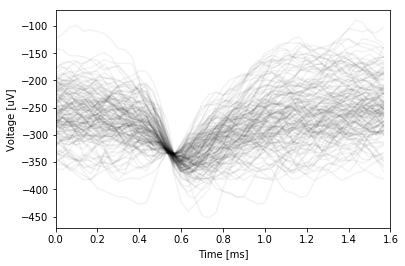

,ch,label,confidence,# prediction switches,# feature vectors
0,1,Artifacts,100.0,0,7


In [4]:
# Write your .ns6 file name
FILE_NAME = r'i140703-001.ns6'

# Assign a label for each channel
empty_outcome_all = True
for ch in range(1,97):
    print(f'CHANNEL {ch}:')
    # Load trace from specific electrode (sys.stdout is used to avoid nasty printing of brpylib)
    sys.stdout = open(os.devnull, "w")
    data = brpylib.NsxFile(FILE_NAME).getdata(elec_ids=[ch], start_time_s=0, data_time_s=120);           
    sys.stdout = sys.__stdout__
    X = data['data'].squeeze()
    N = X.shape[0]
    fs = data['samp_per_s']
    # Filter trace
    X_filtered = filter_signal(X)
    # Set threshold heuristically
    threshold = -4.5 * np.sqrt(np.sum(X**2)/N)
    # Get threshold crossings
    detections = threshold_signal(X, threshold)
    # Extract and plot waveforms
    waveforms, _ = extract_windows(X, detections, window_limits=[16,32])
    if ch==1:
        plot_waveforms(waveforms)

    # Build input (feature maps)
    batch_size = 20
    n_inputs = waveforms.shape[0] // batch_size
    if n_inputs==0:
        print('Not enough waveforms')
    else:
        X = np.zeros((n_inputs, 20, 48, 1))
        for i in range(n_inputs):
            X[i,:,:,0] = waveforms[i*batch_size:(i+1)*batch_size]
        # Preprocess input        
        X_preprocessed = preprocessing(X, mean=parameters['input_mean'])
        # Get model head output
        y_head = model_head.predict(X_preprocessed)
        # Flatten and reshape manually
        X_FC = np.zeros((n_inputs,1,2900))
        for i in range(n_inputs):
            X_FC[i,0,:] = y_head[i].T.flatten()
        # Get model tail output, i.e. final prediction
        y_pred = model_tail.predict_classes(X_FC)

        # Set channel label with confidence
        trackChanges = np.diff(y_pred.flatten())
        frequencyChangePredictedLabel = np.sum(np.unique(np.cumsum(np.append((np.diff(trackChanges)!=0)[::-1], True)[::-1])[trackChanges!=0])!=0)
        maxOccurredLabel = stats.mode(y_pred.flatten())[0][0]
        percentageMaxOccurredLabel=(stats.mode(y_pred.flatten())[1][0]/n_inputs) * 100
        if X.shape[0]==0:
            outcome = [ch, 'Broken', -1, -1, 0] 
        else:
            if maxOccurredLabel==0:
                outcome = [ch, 'Neural', np.round(percentageMaxOccurredLabel,2), frequencyChangePredictedLabel, n_inputs]
            else:
                outcome = [ch, 'Artifacts', np.round(percentageMaxOccurredLabel,2), frequencyChangePredictedLabel, n_inputs]
        
        if ch==1:
            display(pd.DataFrame([outcome], columns=['ch', 'label', 'confidence', '# prediction switches', '# feature vectors']))
        
        # Gather outcome for all channels in an array
        if empty_outcome_all==True:
            outcome_all = outcome
            empty_outcome_all=False
        else:
            outcome_all = np.vstack((outcome_all, outcome))

In [5]:
# Gather all the outcome in a DataFrame
outcome_df = pd.DataFrame(outcome_all, columns=['ch', 'label', 'confidence [%]', '# prediction switches', '# feature vectors'])
display(outcome_df[10:20])

,ch,label,confidence [%],# prediction switches,# feature vectors
10,12,Artifacts,100.0,0,1
11,13,Artifacts,100.0,0,25
12,14,Neural,85.71,30,126
13,16,Artifacts,100.0,0,2
14,18,Artifacts,80.56,10,36
15,19,Artifacts,100.0,0,40
16,20,Artifacts,100.0,0,10
17,21,Artifacts,100.0,0,5
18,22,Neural,57.14,23,63
19,24,Artifacts,100.0,0,32
